In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc



/var/folders/9z/p4m8knns6vdgtlg0pbzyzqk97yrkj2/T/ipykernel_83304/905079576.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
all_files=[]
import os
for root, dirs, files in os.walk("./data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [5]:
dfs=[]
for path in all_files:
    df = pd.read_csv(path,index_col='datetime',sep=';',parse_dates=True)
    dfs.append(df)
print('Features:')
for col in dfs[2].columns:
    print('\t',col)

Features:
	 Accelerometer1RMS
	 Accelerometer2RMS
	 Current
	 Pressure
	 Temperature
	 Thermocouple
	 Voltage
	 Volume Flow RateRMS
	 anomaly
	 changepoint


In [6]:
print(dfs[2].columns)


Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly', 'changepoint'],
      dtype='object')


In [7]:
def calc_metrics(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  cm = confusion_matrix(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  return accuracy,cm,f1,fpr, tpr, thresholds, roc_auc
 
def plot(cm, fpr, tpr, roc_auc, title = 'Model Evaluation Metrics'):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
  fig.suptitle(title, fontsize=16, y=1.02)
  # Confusion Matrix in the first subplot
  # sns.heatmap(cm, annot=True, fmt="d", ax=ax[0])
  ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax[0])
  ax[0].set_title('Confusion Matrix')
  ax[0].set_xlabel('Predicted labels')
  ax[0].set_ylabel('True labels')

  # ROC Curve in the second subplot
  ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
  ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  ax[1].set_xlabel('False Positive Rate')
  ax[1].set_ylabel('True Positive Rate')
  ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
  ax[1].legend(loc='lower right')

  # Display the plot
  plt.tight_layout()
  plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 320, number of negative: 603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1581
[LightGBM] [Info] Number of data points in the train set: 923, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346696 -> initscore=-0.633596
[LightGBM] [Info] Start training from score -0.633596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

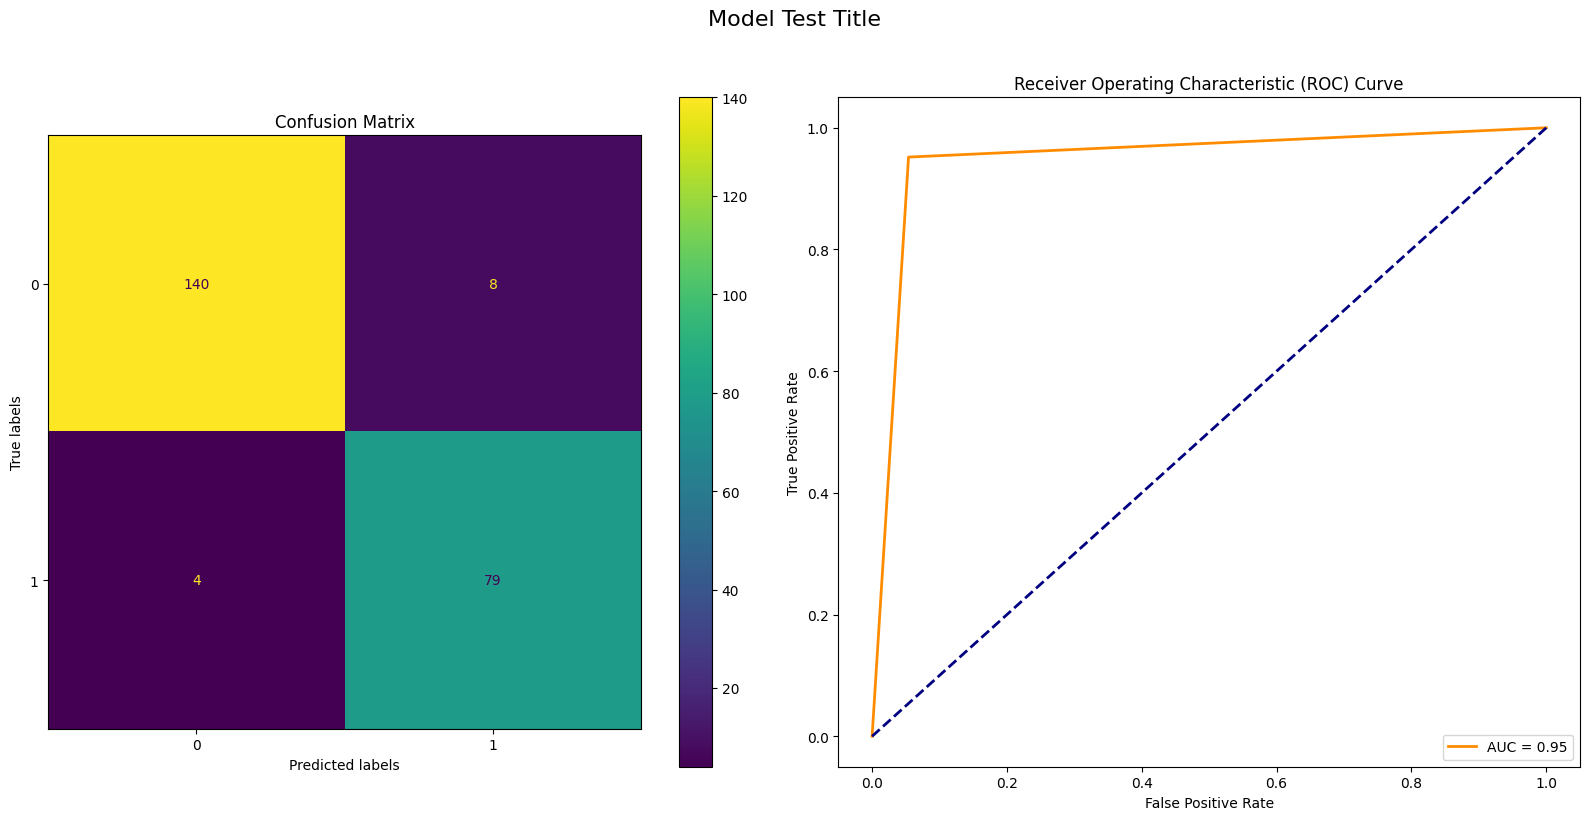

In [8]:
X = dfs[2].drop('anomaly', axis=1)
y = dfs[2]['anomaly']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# LightGBM model
lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(X_train, y_train)


y_pred = lgbm_model.predict(X_test)

# Evaluate
accuracy, cm, f1, fpr, tpr, thresholds, roc_auc = calc_metrics(y_test,y_pred)
plot(cm, fpr, tpr, roc_auc, title = 'Model Test Title')



Model Accuracy: 0.948051948051948
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 320, number of negative: 603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 923, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346696 -> initscore=-0.633596
[LightGBM] [Info] Start training from score -0.633596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

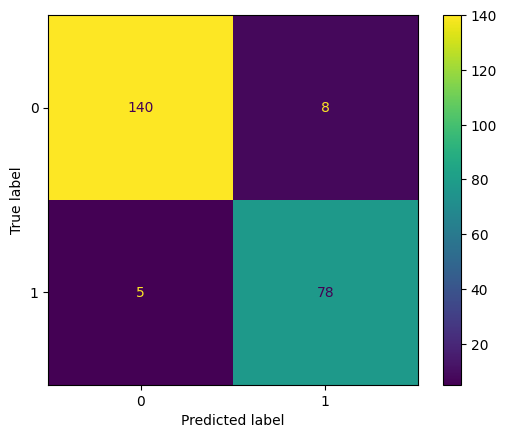

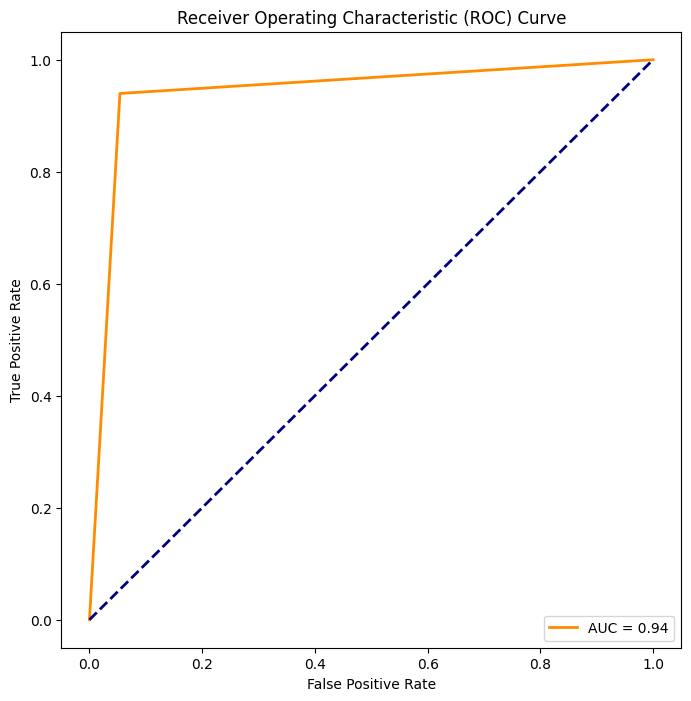

In [9]:
print(f"Model Accuracy: {accuracy}")# 1. Feature Importance Analysis
feature_importances = lgbm_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Select Top Features
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(int(len(feature_names) * 0.85))['feature']

# Using only the top features for training
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]


lgbm_model_top = lgb.LGBMClassifier()
lgbm_model_top.fit(X_train_top, y_train)


y_pred_top = lgbm_model_top.predict(X_test_top)
accuracy_top = accuracy_score(y_test, y_pred_top)
print(f"Model Accuracy with Top Features: {accuracy_top}")

cm = confusion_matrix(y_test, y_pred_top)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_top)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr,tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Normalization
scaler_minmax = MinMaxScaler()
X_train_normalized = scaler_minmax.fit_transform(X_train)
X_test_normalized = scaler_minmax.transform(X_test)

# Standardization
scaler_standard = StandardScaler()
X_train_standardized = scaler_standard.fit_transform(X_train)
X_test_standardized = scaler_standard.transform(X_test)

# Retrain and Evaluate the model with normalized data
lgbm_model_normalized = lgb.LGBMClassifier()
lgbm_model_normalized.fit(X_train_normalized, y_train)
y_pred_normalized = lgbm_model_normalized.predict(X_test_normalized)
accuracy_normalized = accuracy_score(y_test, y_pred_normalized)

# Retrain and Evaluate the model with standardized data
lgbm_model_standardized = lgb.LGBMClassifier()
lgbm_model_standardized.fit(X_train_standardized, y_train)
y_pred_standardized = lgbm_model_standardized.predict(X_test_standardized)
accuracy_standardized = accuracy_score(y_test, y_pred_standardized)

print(f"Model Accuracy with Normalized Data: {accuracy_normalized}")
print(f"Model Accuracy with Standardized Data: {accuracy_standardized}")

cm = confusion_matrix(y_test, y_pred_standardized)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_standardized)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr,tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


: 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np

# Handling missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Normalization
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# RFE - Advanced Feature Selection
rfe = RFE(lgb.LGBMClassifier(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_poly, y)

X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=0)
lgbm_model_combined = lgb.LGBMClassifier()
lgbm_model_combined.fit(X_train, y_train)
y_pred_combined = lgbm_model_combined.predict(X_test)
accuracy_combined = accuracy_score(y_test, y_pred_combined)

print(f"Model Accuracy with Combined Approach: {accuracy_combined}")


cm = confusion_matrix(y_test, y_pred_combined)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_combined)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr,tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

: 

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import f1_score
lgbm_base = lgb.LGBMClassifier()

# Bagging Classifier
bagging_model = BaggingClassifier(base_estimator=lgbm_base,
                                  n_estimators=50,
                                  random_state=0)

bagging_model.fit(X_train, y_train)

y_pred_bagging = bagging_model.predict(X_test)
f1_bagging = f1_score(y_test, y_pred_bagging)

print(f"Model F1 Score with Bagging: {f1_bagging}")

cm = confusion_matrix(y_test, y_pred_bagging)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_bagging)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
#plt.plot(fpr,tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot(fpr,tpr, lw=2, label=f'AUC1 = {roc_auc:.2f}')
plt.plot(0.5*fpr,0.5*tpr, lw=2, label=f'AUC2 = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

: 

In [ ]:
import seaborn as sns

: 

In [ ]:
y_true = np.array([1, 0, 1, 2, 1, 0, 1, 2, 2, 0])
y_pred = np.array([1, 0, 1, 2, 1, 0, 2, 1, 2, 0])

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

: 

: 